# Introduction to Machine Learning: Classification with k-Nearest Neighbors
## Patrick Chao 1/21/18
### (Adapted from Data 8 Fall 2017 Project 3)

# Introduction
The tutorial is centered around the third project from Data 8 Fall 2017. This project involves classifying a movie's genre as either action or romance using k-Nearest Neighbors.

# Classification vs Regression
In general, there are two major types of machine learning problems, classification and regression.

*Classification* is a problem where we would like to *classify* some sample input into a class or category. For example, we could classify the genre of a movie or classify a handwritten digit as $0-9$. The input may be a list of **features**, or *qualities* of a sample (for digits this would the individual pixels of the image), and the output is a class or label. Note that the bins are discrete and often categorical, and there are a finite number of classes. 

For modeling classification problems, this may involve generating a probability for each class, and selecting the class with the highest probability. In this notebook, we will investigate a simpler model, using a method called *k-nearest neighbors*.

*Regression* does not depend on distinct classes for labels. The input is still a set of features, but the output is instead a continuous value. This may be predicting the population in $5$ years or the temperature tomorrow. In this situation, the "right answer" is more vague. If we predict the temperature to be $70$ degrees tomorrow but it is actually $71$, are we right? What if we predicted $70.5$ degrees? This adds a layer of complexity between regression and classification. 

For modeling regression problems this may be done by creating some function approximation in terms of the input. For example, linear regression is the simplest model, and outputs a continuous value. There are more complex models such as *neural networks* that act as universal function approximators.

# k-Nearest Neighbors
The **k-Nearest Neighbors** (kNN) algorithm is one of the simplest models. The core idea is that a similar set of features should have the same label. For example if we receive an image $A$ as input where we would like to classify the digit, we could look at what other images look like $A$ in our training set. If we were doing $5$-nearest neighbors, we would find the $5$ images closest to $A$ in our data set, and return the most common digit among the $5$. In general, you may choose any value for $k$, $5$ may not be the best choice. Note, this has a $O(1)$ training time! This is the fastest algorithm for training, as there is no training!

However, some questions immediately arise. How do you determine how close two images are? Why choose $5$, not $10$ or $100$? There are other consequences as well; you need to look through your entire dataset each time to determine the $k$ closest images, which could take a long time if your training set is huge. The prediction time for kNN is $O(n)$, which is much slower than something like linear regression, where the prediction is $O(d)$ where $d$ is the number of dimensions of the input data.

We will address these questions and the shortcomings of kNN.

A few conceptual questions for understanding:
1. In binary classification (two classes), why is choosing an odd value for $k$ better than an even value?
2. Given two separate ordered pairs of two values, $(a,b)$ and $(x,y)$, what possibilities are there for calculating the "distance" between them? What are the differences between approaches?
3. Assume we are doing image classification. List any possible issues with image classification.
4. What does 1-NN mean? If we have $n$ training data, what is $n$-NN? What are some of the *tradeoffs* for varying $k$ between $1$ and $n$?

In [1]:
# Run this cell to set up the notebook
import numpy as np
import math

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
#You may need to pip install pandas/matplotlib

#Given a movie title, this returns the frequency of given words
def wordFreq(movieTitle,words):
    #Change movieTitle to lower case
    movieTitle=movieTitle.lower()
    
    #Change words to lower case
    words = [word.lower() for word in words]
    #Check if movie title is found
    try:
        movie = movies[movies["Title"]==movieTitle]
    except:
        print("Movie title not found!")
        return ""
    
    #Check if given words are not found
    try:
        wordFrequencies = movie[words].as_matrix()[0]
    except:
        print("Words not found")
        return ""
    
    return wordFrequencies


In [3]:
#Let's see what our dataset looks like!
movies = pd.read_csv('movies.csv')
movies.head()

,Title,Genre,Year,Rating,# Votes,# Words,i,the,to,a,...,foster,pub,vegetarian,garrison,grammoo,chimney,bikini,richter,psychopath,fling
0,the terminator,action,1984,8.1,183538,1849,0.040022,0.043807,0.025419,0.024878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,batman,action,1989,7.6,112731,2836,0.051481,0.033850,0.023977,0.028209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,tomorrow never dies,action,1997,6.4,47198,4215,0.028707,0.054330,0.030368,0.021827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000237,0.0
3,batman forever,action,1995,5.4,77223,3032,0.036609,0.042216,0.020449,0.031003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,supergirl,action,1984,4.1,6576,3842,0.041905,0.032275,0.028891,0.026288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [4]:
#What type is movies?
print(type(movies))

#What is the frequency of the words "hey" and "i" in the matrix? Try some yourself! 
print(wordFreq("batman",["Hey","i"]))


<class 'pandas.core.frame.DataFrame'>
[0.00035261 0.05148096]


## kNN Classification and Feature Selection
Our goal is to be able to classify songs based on the frequency of various words in the script. However it is not feasible to use all the words as that is very calculation intensive. An alternative is to select certain features, but what features do we select? One method to look at which words are often in romance movies but not action, and vice versa. This is called **feature selection**. 

First, we will separate the data into training and validation data. Next, we may create some elementary functions such as the distance between movies, getting movies as pandas series, and finding the $k$ movies closest to some given movie.

In [5]:
#Split the data into 80 training and 20 validation
trainingPercentage = 80/100
numMovies = movies.shape[0]
numTraining = (int)(numMovies*trainingPercentage)
numValidation = numMovies - numTraining

#Training Set
trainingSet = movies[0:numTraining]

#Validation Set
validationSet = movies[numTraining:]


In [6]:
#Separate into action and romance
action = trainingSet[trainingSet["Genre"]=="action"]
romance = trainingSet[trainingSet["Genre"]=="romance"]

In [7]:
#Given two movie titles mov1,mov2, and a list of words
#distance returns the euclidean distance between the two movies using the words as features
def distance(mov1,mov2,words):
    mov1Freq=wordFreq(mov1,words)
    mov2Freq=wordFreq(mov2,words)
    return np.sqrt(sum((mov1Freq-mov2Freq)**2))

#Given a movie title, this returns the row as a pandas series
def getMovie(title):
    title = title.lower()
    return movies[movies["Title"]==title].squeeze()

#Given a movie as a panda series, determines the k closest movies using words as features
#Returns the dataframe of movies
def kShortestDistance(k,movie,movieSet,words):
    distances=[]
    #Iterate over all movies
    for i in range(movieSet.shape[0]):
        currMovieTitle = movieSet.iloc[i]["Title"]
        #Get the distance of two movies from two movies 
        dist = distance(currMovieTitle,movie["Title"],words)
        distances.append((dist,i))
    #Sort the array
    distances = sorted(distances,key=lambda x:x[0])
    #Get the indices of the movies
    indices = [x[1] for x in distances]
    return movieSet.iloc[indices[1:k+1]]

#Faster kShortestDistance using subsetting
def kShortestDistanceFast(k,movie,movieSet,words):
    #Subset out the words
    movieSubset = movieSet[words]
    currMovie = movie[words].squeeze()
    #Calculate Distances and sort
    distances = ((movieSubset-currMovie)**2).sum(axis=1)
    distances = distances.sort_values()
    #Shift by the minimum index if the movies do not start at 0
    indices = distances.index.tolist()
    minIndex = min(indices)
    shiftedIndices=(np.array(indices)-minIndex).tolist()
    return movieSet.iloc[shiftedIndices[1:k+1]]

#Given a list of movies, returns the majority genre
def getMajority(nearestMovies):
    numMovies = nearestMovies.shape[0]
    #Count frequency of genres
    counts = nearestMovies['Genre'].value_counts()
    if len(counts)==1:
        return [x[0] for x in counts.items()][0]
    if counts["action"]>numMovies/2:
        return "action"
    return "romance"

#Given a dataset, a set of word features, and the value of k
#Returns the percentage correct (0-100)
def accuracy(dataset,features,k):
    numCorrect = 0 
    #Iterate over all movies
    for i in range(dataset.shape[0]):
        currMovie = dataset.iloc[i].squeeze()
        currMovieGenre = currMovie["Genre"]
        #Calculate k closest movies
        kClosest = kShortestDistanceFast(k,currMovie,dataset,features)
        predGenre = getMajority(kClosest)
        #Keep track of number of correct predictions
        if predGenre == currMovieGenre:
            numCorrect +=1
    #Return accuracy as percentage
    return numCorrect*1.0/dataset.shape[0]*100

The code below uses "power" and "love" as features to find the $5$ closest movies to "batman returns". Then we get the majority of the genres of those five movies, and we find that batman returns is predicted to be action based on those $5$ movies. 

In [9]:
#Use "money" and "feel" as features
features = ["power","love"]
movie = getMovie("batman returns")
#Get the five closest movies to the "batman returns" using the training set
closest=kShortestDistance(5,movie,trainingSet,features)
#Given the closest movies, returns the majority 
#Represents the kNN Prediction
getMajority(closest)

'action'

Use this word plot (courtesy of Data 8) to construct some of your own features!
<img src='wordplot.png' width="700" height="700">

In [10]:
#Try with some of your own features!
features = ["power","feel"]
k=5
accuracy(trainingSet,features,k)

62.17616580310881

In [11]:
#Our chosen features
features = ["men","power","marri","nice","home","captain","move","run","world","huh","happi","move","write","hello"]

With our own chosen features, we then use the training set to determine the optimal value for $k$. Afterwards, we use this value of $k$ to find the accuracy on the validation data.

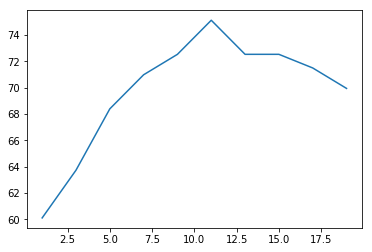

In [12]:
#Determine the best value for k
trainAccuracies = []
numKValues = 10
for i in range(numKValues):
    acc =accuracy(trainingSet,features,2*i+1)
    trainAccuracies.append(acc)
xAxis = ([2*i+1 for i in range(numKValues)])
plt.plot(xAxis,trainAccuracies)
plt.show()



Using the previous information about overfitting and underfitting, explain the shape of the graph! Why is the accuracy low for $k=1$ and as $k$ increases past $15$?

In [13]:
#Determine best value for k
optimalK=xAxis[np.argmax(trainAccuracies)]

#Best kNN was found with k=11
print("Best k:",optimalK)

#Determine validation error with this value for k
optimalKNNVal = accuracy(validationSet,features,optimalK)
print("Test Accuracy:",optimalKNNVal)


Best k: 11
Test Accuracy: 71.42857142857143


Why is the accuracy for the validation set lower than the training accuracy (about $75\%$)?

This concludes the kNN python tutorial. k-Nearest Neighbors is an incredibly simple yet powerful model, and serves as a great foundational method for machine learning.